In [ ]:
# Load the CSV file as an RDD
flights_path = "gs://selected-flights-bucket1/BIG_DATA_DATA.csv"

flight_data = spark.read.csv(flights_path, header=True)

In [ ]:
from pyspark.sql.functions import col

#Converting to intergers
for column in flight_data.columns:
    flight_data = flight_data.withColumn(column, flight_data[column].cast("int"))

#Print the schema again to verify the changes
flight_data.printSchema()

## 3. Modelling

Predicting difference between actual CO2 emission for the flights vs average for that route.

y = CO2 % change

predictors = nr of stops + carrier + price + departure time + arrival time + aircraft type + dep airport + arrival airport + duration

### 3.1 Linear Regression

#### 3.1.1. Training the model

In [ ]:
#Splitting data
flights_train, flights_test = flight_data.randomSplit([0.8, 0.2], seed=1)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Get all columns from flight_data
all_columns = flight_data.columns

# Exclude 'co2_percentage' from predictors
predictors = [col for col in all_columns if col != 'co2_percentage']

# Create the VectorAssembler
features_creator = VectorAssembler(
    inputCols=predictors,  # input columns
    outputCol='features'   # output is a single column with all the features
)

In [ ]:
import pyspark.ml.regression as reg

lr_model = reg.LinearRegression(  # logistic regression model 
    maxIter = 10,                  # maximum number of iterations (>= 0)
    regParam = 0.01,               # regularization parameter (>= 0)
    labelCol = 'co2_percentage')            # label column name.

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[
        features_creator, # transformer
        lr_model         # estimator
    ])

In [ ]:
model = pipeline.fit(flights_train)

In [ ]:
#Apply the trained model over the testing data
test_model = model.transform(flights_test)

#### 3.1.2. Model Performance Evaluation

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create an evaluator for each metric
evaluator_mae = RegressionEvaluator(
    labelCol="co2_percentage", 
    predictionCol="prediction", 
    metricName="mae"
)

evaluator_rmse = RegressionEvaluator(
    labelCol="co2_percentage", 
    predictionCol="prediction", 
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="co2_percentage", 
    predictionCol="prediction", 
    metricName="r2"
)

# Calculate the metrics
mae = evaluator_mae.evaluate(test_model)
rmse = evaluator_rmse.evaluate(test_model)
r2 = evaluator_r2.evaluate(test_model)

print("Mean Absolute Error (MAE) on test data:", mae)
print("Root Mean Squared Error (RMSE) on test data:", rmse)
print("R-squared (R2) on test data:", r2)


Mean Absolute Error (MAE) on test data: 44.73560613457575
Root Mean Squared Error (RMSE) on test data: 73.44574545193811
R-squared (R2) on test data: 0.30239199589066923


#### 3.1.3. Extracting coefficients 

**Top 20 Feature Coefficients**

In [ ]:
# Extract the coefficients from the trained linear regression model
coefficients = model.stages[-1].coefficients

# Map feature names to coefficients
feature_coefficients = [(feature, coefficient) for feature, coefficient in zip(predictors, coefficients)]

# Sort the feature coefficients by the absolute coefficient value in descending order
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

top_20_feature_coefficients = sorted_feature_coefficients[:20]
for feature, coefficient in top_20_feature_coefficients:
    print(f"{feature}: {coefficient}")


Cayman Airways: 648.9711246664662
Bahamasair: 231.38364934778207
Airbus A220 Passenger: 215.47841770693853
Air Botswana: -190.83144405147408
Embraer ERJ 135 145: 177.5774634347739
FlySafair: -121.34142215295874
Embraer RJ 170 190: 98.36688346092573
LIFT operated as Global Aviation: -93.54205121776468
dest_airport_code_CAN: -83.37762479180465
dest_airport_code_JFK: 81.91092042291532
dest_airport_code_XIY: -77.75550180825445
Zambia Airways  2014: -77.06766942547604
Boeing 737MAX 7 Passenger: -76.74378693458135
AccesRail: -76.33044666789914
Airlink: -75.21355648338425
S7: -73.99823247104777
Canadair RJ 200: 70.11196399131073
from_airport_code_SZX: -69.3274407218026
Jin Air: -65.66902259607097
from_airport_code_CAN: -63.889608413587965


**Features with negative coefficients**

In [ ]:
# Filter features with negative coefficients
negative_feature_coefficients = [(feature, coefficient) for feature, coefficient in sorted_feature_coefficients if coefficient < 0]

# Print features with negative coefficients
for feature, coefficient in negative_feature_coefficients:
    print(f"{feature}: {coefficient}")

Air Botswana: -190.83144405147408
FlySafair: -121.34142215295874
LIFT operated as Global Aviation: -93.54205121776468
dest_airport_code_CAN: -83.37762479180465
dest_airport_code_XIY: -77.75550180825445
Zambia Airways  2014: -77.06766942547604
Boeing 737MAX 7 Passenger: -76.74378693458135
AccesRail: -76.33044666789914
Airlink: -75.21355648338425
S7: -73.99823247104777
from_airport_code_SZX: -69.3274407218026
Jin Air: -65.66902259607097
from_airport_code_CAN: -63.889608413587965
Sun Country Airlines: -63.00840762838892
from_airport_code_CTU: -61.58585014058033
dest_airport_code_PEK: -56.70498873151112
Star Flyer: -55.50649612683903
from_airport_code_PEK: -55.475448629438795
Iberojet: -53.39406033614441
FlyEgypt: -53.367499340833945
Corendon: -52.86877493073899
Aeroflot: -52.26523829489555
T Way Air: -51.68466274644217
from_airport_code_SHA: -51.20968487862378
from_airport_code_PVG: -51.046722907173326
Airbus A330 800neo Passenger: -48.98062460884215
F B  Lineas Aereas: -45.98526976708813

### 3.2 Logistic Regression

#### 3.2.1. Training the model

<code>Binary classification</code>: we want to predict whether a route has improved its emissions or not. 
Based on this schema, we will create a column <code>emission_improv</code> with values improved (class 1) and not improved (class 0) based on whether the co2 percentage column is negative or not.

In [ ]:
#Dataset labelling
from pyspark.sql import functions as sql_f

#Add a new column based on the whether co2 percentage is negative
# negative means improved 
classification_df = flight_data.withColumn('emission_improv', 
                                           sql_f.when(flight_data["co2_percentage"] < 0, 1)
                                                .otherwise(0))
#Drop original column
classification_df = classification_df.drop("co2_percentage")

In [ ]:
#Splitting data
flights_train, flights_test = classification_df.randomSplit([0.8, 0.2], seed=1)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Get all columns from flight_data
all_columns = classification_df.columns

# Exclude 'co2_percentage' from predictors
predictors = [col for col in all_columns if col != 'emission_improv']

# Create the VectorAssembler
features_creator = VectorAssembler(
    inputCols=predictors,  # input columns
    outputCol='features'   # output is a single column with all the features
)

In [ ]:
import pyspark.ml.classification as cl

logr_model = cl.LogisticRegression(  # logistic regression model 
    maxIter = 10,                  # maximum number of iterations (>= 0)
    regParam = 0.01,               # regularization parameter (>= 0)
    labelCol = 'emission_improv')            # label column name.

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[
        features_creator, # transformer
        logr_model         # estimator
    ])

In [ ]:
model = pipeline.fit(flights_train)

In [ ]:
test_model = model.transform(flights_test)

#### 3.2.2. Model Performance Evaluation

In [ ]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator( # for binary classification error estimation
    rawPredictionCol = 'probability', 
    labelCol = 'emission_improv')

print('Area under ROC: ', evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(' Area under PR: ', evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

Area under ROC:  0.8599166457425411


 Area under PR:  0.6374687285142092


#### 3.2.3. Extracting coefficients

**Top 20 Feature Coefficients**

In [ ]:
# Extract the coefficients from the trained logistic regression model
coefficients = model.stages[-1].coefficients

# Map feature names to coefficients
feature_coefficients = [(feature, coefficient) for feature, coefficient in zip(predictors, coefficients)]

# Sort the feature coefficients by the absolute coefficient value in descending order
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

top_20_feature_coefficients = sorted_feature_coefficients[:20]
for feature, coefficient in top_20_feature_coefficients:
    print(f"{feature}: {coefficient}")

Zambia Airways  2014: 4.169463259687807
T Way Air: 4.166186011655949
Indonesia AirAsia: 3.9265144415794233
FlyEgypt: 3.8903554774341265
Smartwings: 3.8240551751041516
Star Flyer: 3.3950872087190165
Air Botswana: 3.364907978999841
Hong Kong Express: 3.1083194743133933
Belavia: -2.9685887003279845
Jeju Air: -2.876408234346164
dest_airport_code_SVO: -2.854534609868239
Airbus A330 900neo: 2.853439770222252
Allegiant: -2.769735379487579
Embraer ERJ 135 145: -2.6831089109696173
Airbus A340: -2.5880741625827803
TUI Airways: -2.435683518578194
Cayman Airways: -2.4081563265954933
Airbus A330 800neo Passenger: -2.4041053881316827
Iberojet: -2.3486709798242456
Train: 2.274602712680019


**Features with positive coefficients**

In [ ]:
# Filter features with negative coefficients
pos_feature_coefficients = [(feature, coefficient) for feature, coefficient in sorted_feature_coefficients if coefficient > 0]

# Print features with negative coefficients
for feature, coefficient in pos_feature_coefficients:
    print(f"{feature}: {coefficient}")

Belavia: -2.9685887003279845
Jeju Air: -2.876408234346164
dest_airport_code_SVO: -2.854534609868239
Allegiant: -2.769735379487579
Embraer ERJ 135 145: -2.6831089109696173
Airbus A340: -2.5880741625827803
TUI Airways: -2.435683518578194
Cayman Airways: -2.4081563265954933
Airbus A330 800neo Passenger: -2.4041053881316827
Iberojet: -2.3486709798242456
TAR Aerolineas: -2.2490592951232244
dest_airport_code_DME: -2.179694181855544
LIFT operated as Global Aviation: -2.1350639452401197
Aeromar: -2.127750463667545
F B  Lineas Aereas: -2.000609956501957
Canadair RJ 200: -1.997113685041522
Porter Airlines: -1.9793134174118647
Bahamasair: -1.8717568623719947
dest_airport_code_HGH: -1.8436664207655649
Canadair Reg  Jet: -1.8392870627915305
Airbus A220 Passenger: -1.8021094611343471
Firefly: -1.639466869198565
Air Corsica: -1.4841818091037349
Philippines AirAsia: -1.4648648814143832
Embraer ERJ 145: -1.374776013121848
Bombardier Regional Jet 550: -1.2469030180112928
Eastern Airways: -1.168544089181

In [1]:
from pyspark.sql.types import StructType, StructField, IntegerType
flights_path = "gs://selected-flights-bucket1/BIG_DATA_DATA.csv"

# Load the CSV file to infer the schema
flight_data = spark.read.csv(flights_path, header=True, inferSchema=True)
#flight_data.head(5)

### 3.3. Random Forest Classifier

In [1]:
from pyspark.sql.types import StructType, StructField, IntegerType
flights_path = "gs://selected-flights-bucket1/BIG_DATA_DATA.csv"

# Load the CSV file to infer the schema
flight_data = spark.read.csv(flights_path, header=True, inferSchema=True)
#flight_data.head(5)

In [2]:
# dataset labelling
from pyspark.sql import functions as sql_f

# Add a new column based on the whether co2 percentage is negative
# negative means improved 
classification_df = flight_data.withColumn('emission_improv', 
                                           sql_f.when(flight_data["co2_percentage"] < 0, 1)
                                                .otherwise(0))
# drop original column
classification_df = classification_df.drop("co2_percentage")

#### 3.3.1 Exploring class imbalance

In [3]:
# Group by the 'emission_improv' column and count the occurrences of each classification
classification_counts = classification_df.groupBy("emission_improv").count()

# Show the counts
classification_counts.show()

+---------------+------+
|emission_improv| count|
+---------------+------+
|              1| 71096|
|              0|225125|
+---------------+------+



The classes are imbalanced -- there are over 3 times as many routes that have worser emission levels than average for that route, hence there will be bias towards the majority class and difficulty for the model to learn minority class patterns.

https://medium.com/data-and-beyond/exploring-pyspark-ml-for-machine-learning-handling-class-imbalances-part-1-2-786e129cedc7#:~:text=Data%20Resampling%20%E2%80%94%20A%20common%20method,dataset%20you%20have%20at%20hand.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import confusion_matrix

In [4]:
# Set the train/test ratio
train_test_ratio = 0.8

# Split the data into training and testing sets using stratified sampling
train_data_class_improved = classification_df.filter(F.col('emission_improv')=='1').sample(fraction=train_test_ratio, seed=88)
train_data_class_not_improved = classification_df.filter(F.col('emission_improv')=='0').sample(fraction=train_test_ratio, seed=88)
train_data = train_data_class_improved.union(train_data_class_not_improved)
test_data = classification_df.subtract(train_data)

# Print the number of samples in each set
print("Training Set Size:", train_data.count())
print("Testing Set Size:", test_data.count())
print("Improved class fraction in Training Set Size:", train_data.filter(F.col('emission_improv')=='1').count()/train_data.count())
print("Improved class fraction in Test Set Size:", test_data.filter(F.col('emission_improv')=='1').count()/test_data.count())

Training Set Size: 237124


24/04/26 21:24:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Testing Set Size: 43071


Improved class fraction in Training Set Size: 0.24020955902480934


Improved class fraction in Test Set Size: 0.2355180980241926


Split the data into train and test and have double checked that the fraction of the minority in the training and test size are similar.

#### 3.3.2 Baseline model without SMOTE

Created a baseline model of a Random Forest Classifier Model (no parallelisation) so that we can compare this result with the use of data resampling.

In [5]:
from pyspark.ml.feature import VectorAssembler
def assemble_features(df):
    # Assemble the features into a Vector to feed the Model.
    feature_list = [col for col in train_data.columns if col != "emission_improv"]
    assembler = VectorAssembler(inputCols=feature_list, outputCol='features_for_model')
    model_df1 = assembler.transform(df)
    
    return model_df1

def train_model(train_df):
    model_df = assemble_features(train_df)
    # Initiate the Random Forest Classifier Model
    rf = RandomForestClassifier(featuresCol='features_for_model', labelCol='emission_improv', seed=88)
    rf_model = rf.fit(model_df)
    
    return rf_model

def test_model(test_df, model):
    model_df = assemble_features(test_df)
    
    prediction = model.transform(model_df)
    
    return prediction

In [68]:
# Initiate the Random Forest Classifier Model
rf_model = train_model(train_data)

In [69]:
# Test the Model
prediction = test_model(test_data, rf_model)

In [ ]:
# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='emission_improv')
auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

print(f"AUROC: {auroc}")
print(f"AUPR: {aupr}")

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert labels to double
pred_rdd = prediction.select(prediction['prediction'].cast('double'), prediction['emission_improv'].cast('double')).rdd.map(tuple)

# Create MulticlassMetrics object
metrics = MulticlassMetrics(pred_rdd)

# Calculate evaluation metrics
accuracy_o = metrics.accuracy
precision_o = metrics.precision(1.0)  # Positive class
recall_o = metrics.recall(1.0)  # Positive class
f1_o = metrics.fMeasure(1.0)  # Positive class

# Print the results
print("Accuracy:", accuracy_o)
print("Precision:", precision_o)
print("Recall:", recall_o)
print("F1-score:", f1_o)


24/04/26 21:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1072.9 KiB
24/04/26 21:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1083.4 KiB


Accuracy: 0.7644819019758073
Precision: 0.0
Recall: 0.0
F1-score: 0.0


DenseMatrix([[32927.,     0.],
             [10144.,     0.]])


/tmp/ipykernel_12053/1090856182.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_12053/1090856182.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


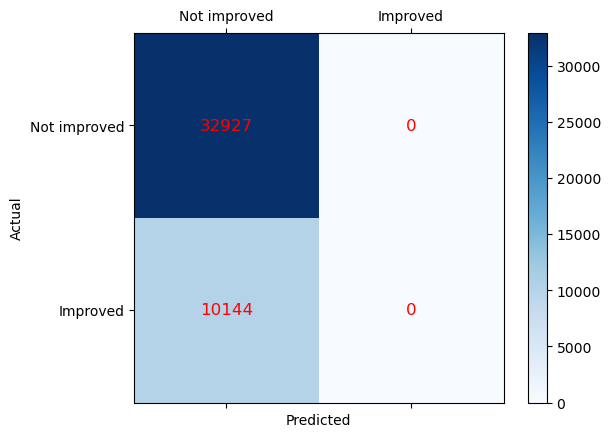

In [11]:
# Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
# Meaning 0 1 in columns. Rows also 0 then 1.
print(metrics.confusionMatrix())

confusion_matrix = metrics.confusionMatrix().toArray()
labels = ['Not improved', 'Improved']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
# Add actual values to the cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Although it is clear that there is a high accuracy, this is derived from the high amount of True Negatives. Recall is incredibly low, suggesting the model cannot correctly predict routes with improved emissions. Thus, we attempt to improve this model by through undersampling the majority class, which is in this case routes that have not improved emissions.

#### 3.3.3 Undersample majority

In [12]:
# Create undersampling function
def undersample_majority(df, ratio=1):
    minority_count = df.filter(F.col('emission_improv')==1).count()
    whole_count = df.count()
    undersampled_majority = df.filter(F.col('emission_improv')==0)\
                                .sample(withReplacement=False, fraction=(ratio*minority_count/whole_count),seed=88)
    undersampled_df = df.filter(F.col('emission_improv')==1).union(undersampled_majority)
    
    return undersampled_df

In [13]:
train_data_undersampled = undersample_majority(train_data,1) # ratio 1:1
rf_model1 = train_model(train_data_undersampled)

In [14]:
# Test the Model
prediction1 = test_model(test_data, rf_model1)

In [15]:
# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='emission_improv')
auroc = evaluator.evaluate(prediction1,{evaluator.metricName:'areaUnderROC'})
aupr = evaluator.evaluate(prediction1,{evaluator.metricName:'areaUnderPR'})

print(f"AUROC: {auroc}")
print(f"AUPR: {aupr}")

24/04/26 21:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1082.8 KiB
24/04/26 21:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1082.8 KiB


AUROC: 0.7936719395112541
AUPR: 0.5130998205815572


In [16]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert labels to double
pred_rdd = prediction1.select(prediction1['prediction'].cast('double'), prediction1['emission_improv'].cast('double')).rdd.map(tuple)

# Create MulticlassMetrics object
metrics = MulticlassMetrics(pred_rdd)

# Calculate evaluation metrics
accuracy_o = metrics.accuracy
precision_o = metrics.precision(1.0)  # Positive class
recall_o = metrics.recall(1.0)  # Positive class
f1_o = metrics.fMeasure(1.0)  # Positive class

# Print the results
print("Accuracy:", accuracy_o)
print("Precision:", precision_o)
print("Recall:", recall_o)
print("F1-score:", f1_o)


24/04/26 21:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1083.7 KiB
24/04/26 21:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1094.3 KiB


Accuracy: 0.5595412226323977
Precision: 0.33961989897888734
Recall: 0.9213328075709779
F1-score: 0.496296099620317


DenseMatrix([[14754., 18173.],
             [  798.,  9346.]])


/tmp/ipykernel_12053/1090856182.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_12053/1090856182.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


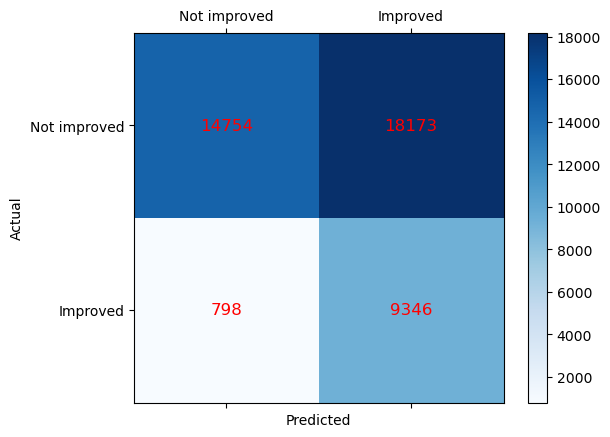

In [17]:
# Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
# Meaning 0 1 in columns. Rows also 0 then 1.
print(metrics.confusionMatrix())

confusion_matrix = metrics.confusionMatrix().toArray()
labels = ['Not improved', 'Improved']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
# Add actual values to the cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 3.4 Ensemble Learning

#### 3.4.1 Data preprocessing

In [18]:
from pyspark.ml.feature import VectorAssembler

# feature cols cannot include output or label
feature_cols = train_data_undersampled.columns
feature_cols.remove('emission_improv')

# generating the features column (for MLlib models)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [19]:
# we need to cache training and testing samples as we want the feature transformation to happen only once
# we will use the assembled features with various classifiers
train_features = assembler.transform(train_data_undersampled).select("features", "emission_improv").cache()
test_features = assembler.transform(test_data).select("features", "emission_improv").cache()

In [20]:
# resampling
# fraction = 1 is the boostrap size, meaning that the 
# size of the training dta would be (almost) the same in each iteratopn
bag = train_features.sample(withReplacement=True, fraction=1.0)

In [21]:
# number of instances per class in the boostrap sample
bag.groupby('emission_improv').count().show()

+---------------+-----+
|emission_improv|count|
+---------------+-----+
|              1|56893|
|              0|43610|
+---------------+-----+



In [22]:
# comparative analysis with the whole dataset
train_data_undersampled.groupby('emission_improv').count().show()

+---------------+-----+
|emission_improv|count|
+---------------+-----+
|              1|57038|
|              0|43377|
+---------------+-----+



#### 3.4.2 Base learner

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(maxDepth=5, labelCol="emission_improv")

In [24]:
dt.setPredictionCol(f'prediction_1')
dt.setProbabilityCol(f'probability_1')
dt.setRawPredictionCol(f'rawPrediction_1')

model = dt.fit(bag)

In [25]:
prediction = model.transform(test_features)
prediction.show(1)

+--------------------+---------------+----------------+--------------------+------------+
|            features|emission_improv| rawPrediction_1|       probability_1|prediction_1|
+--------------------+---------------+----------------+--------------------+------------+
|(274,[50,57,149,1...|              0|[27716.0,9923.0]|[0.73636387789261...|         0.0|
+--------------------+---------------+----------------+--------------------+------------+
only showing top 1 row



#### 3.4.3 Bagging

In [26]:
# returns all fitted models in a list
def bagging(train_df, weak_learner, bootstrap_size, max_iter=10):
    models = []

    for i in range(max_iter):
        bag = train_df.sample(withReplacement=True, fraction=1.0)
        dt.setPredictionCol(f"prediction_{i}")
        dt.setProbabilityCol(f"probability_{i}")
        dt.setRawPredictionCol(f"rawPrediction_{i}")
        models.append(dt.fit(bag))

    return models

In [27]:
# train the models 
max_iter = 10

models = bagging(train_features, dt, 1, max_iter)

In [41]:
# we need to RESET the evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="emission_improv",
    metricName="weightedRecall",
)

In [42]:
# checking the performance of each model
def test_individual_models(test_feat, models):
    for i in range(len(models)):
        prediction = models[i].transform(test_feat)
        evaluator.setPredictionCol(f'prediction_{i}') # Change column
        rec = evaluator.evaluate(prediction)
        print(f"Recall model {i}: {rec}")

In [43]:
test_individual_models(test_features, models)

Recall model 0: 0.7441433911448538


Recall model 1: 0.7288198555872861


Recall model 2: 0.744770263054027


Recall model 3: 0.7463722690441364


Recall model 4: 0.7222260918019084


Recall model 5: 0.7310951684428038


Recall model 6: 0.7311880383552738


Recall model 7: 0.7435397367137981


Recall model 8: 0.7407304218615773


Recall model 9: 0.7444452183603817


In [44]:
from pyspark.ml import PipelineModel

# models has the fitted models, so we can use it in a pipeline
pipeline_models = PipelineModel(stages=models)

In [45]:
# we apply the pipeline of models to transform the test Dataframe, 
# adding columns with the predictions of the number of classifiers we have used 
prediction = pipeline_models.transform(test_features)

In [46]:
ensemble = prediction.select(
    sql_f.array([f"prediction_{i}" for i in range(max_iter)]).alias("preds"),
    "emission_improv",
)
ensemble.show(1, truncate=False)

+--------------------------------------------------+---------------+
|preds                                             |emission_improv|
+--------------------------------------------------+---------------+
|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]|0              |
+--------------------------------------------------+---------------+
only showing top 1 row



In [47]:
from statistics import mode  
from pyspark.sql.types import DoubleType

mode_udf = sql_f.udf(mode, DoubleType()) 
prediction = ensemble.withColumn("prediction", mode_udf("preds"))
prediction.show(1)

+--------------------+---------------+----------+
|               preds|emission_improv|prediction|
+--------------------+---------------+----------+
|[0.0, 0.0, 0.0, 0...|              0|       0.0|
+--------------------+---------------+----------+
only showing top 1 row



#### 3.4.4. Evaluation metrics

In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="emission_improv", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Accuracy:", accuracy)

# Evaluate precision, recall, and F1-score for class 1
evaluator = MulticlassClassificationEvaluator(labelCol="emission_improv", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(prediction)
print("Precision:", precision)

evaluator = MulticlassClassificationEvaluator(labelCol="emission_improv", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(prediction)
print("Recall:", recall)

evaluator = MulticlassClassificationEvaluator(labelCol="emission_improv", predictionCol="prediction", metricName="weightedFMeasure")
f1 = evaluator.evaluate(prediction)
print("F1-score:", f1)

# Evaluate area under the ROC curve (AUC)
evaluator = BinaryClassificationEvaluator(labelCol="emission_improv", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(prediction)
print("AUC:", auc)

Accuracy: 0.7440273037542662


Precision: 0.8102738934644085


Recall: 0.7440273037542662


F1-score: 0.7610382894390405


AUC: 0.7550291713319752


#### 3.4.5. Feature Importance

In [53]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import PipelineModel
from pyspark.sql import functions as sql_f
from pyspark.sql.types import DoubleType

ensemble_feature_importance = []

for i, model in enumerate(models):
    # Extracting feature importance from each individual model
    feature_importance = model.featureImportances
    
    # Convert feature importance to a list of tuples and cast the importance values to float
    feature_importance_tuples = [(feature_cols[j], float(importance)) for j, importance in enumerate(feature_importance)]
    
    # Create DataFrame from the list of tuples
    importance_df = spark.createDataFrame(feature_importance_tuples, ["Feature", "Importance"])
    
    # Adding a column to identify the model
    importance_df = importance_df.withColumn("Model", sql_f.lit(f"Model_{i+1}"))
    
    # Appending feature importance for the current model to the ensemble list
    ensemble_feature_importance.append(importance_df)

ensemble_feature_importance_df = ensemble_feature_importance[0]
for df in ensemble_feature_importance[1:]:
    ensemble_feature_importance_df = ensemble_feature_importance_df.union(df)


In [56]:
from pyspark.sql import Window

# Define an empty list to store the top 10 features for each model
top_10_features_per_model = []

# Loop through each model in the ensemble
for i, model in enumerate(models):
    # Extracting feature importance
    feature_importance = model.featureImportances
    
    # Convert feature importance to a list of tuples and convert importance to float
    feature_importance_tuples = [(feature_cols[j], float(importance)) for j, importance in enumerate(feature_importance)]
    importance_df = spark.createDataFrame(feature_importance_tuples, ["Feature", "Importance"])
    
    # Adding column for model
    importance_df = importance_df.withColumn("Model", sql_f.lit(f"Model_{i+1}"))
    
    # Appending top 10 features for the current model to the list
    top_10_features = importance_df.orderBy(sql_f.desc("Importance")).limit(10)
    top_10_features_per_model.append(top_10_features)

# Concatenating top 10 features from all models into a single DataFrame
features_df = top_10_features_per_model[0]
for df in top_10_features_per_model[1:]:
    features_df = features_df.union(df)

# Displaying top 10 features for each model
features_df.orderBy("Model", sql_f.desc("Importance")).show()

+------------------+--------------------+--------+
|           Feature|          Importance|   Model|
+------------------+--------------------+--------+
|        Boeing 787| 0.31795654528554196| Model_1|
|       Airbus A350|  0.2857024305260381| Model_1|
|Airbus A330 900neo| 0.13181450244159318| Model_1|
|    Airbus A321neo| 0.07118615673441529| Model_1|
|             price|0.054864752970317225| Model_1|
|        Boeing 777|   0.054543079417903| Model_1|
|             stops| 0.04636724316456037| Model_1|
|   Embraer ERJ 145|0.008930462065763846| Model_1|
|       Airbus A380|0.004473127628179093| Model_1|
|        Air France|0.003249065466919...| Model_1|
|        Boeing 787| 0.31906568617911896|Model_10|
|       Airbus A350|  0.3012092751713337|Model_10|
|Airbus A330 900neo|  0.1259071428198496|Model_10|
|    Airbus A321neo| 0.07082757403718931|Model_10|
|        Boeing 777|0.054714346293243996|Model_10|
|             stops| 0.04591886803244138|Model_10|
|             price| 0.04024275

In [63]:
from pyspark.sql.functions import sum

# Group by feature and sum up importances across all models
total_importances = features_df.groupBy("Feature").agg(sum("Importance").alias("TotalImportance"))

# Order by total importances in descending order and show top 10 features
top_10_features_total = total_importances.orderBy(sql_f.desc("TotalImportance")).limit(10)

# Display top 10 features based on total importances
top_10_features_total.show()

+------------------+--------------------+
|           Feature|     TotalImportance|
+------------------+--------------------+
|        Boeing 787|   3.201021283112645|
|       Airbus A350|  2.9418521648737634|
|Airbus A330 900neo|  1.2796072393627327|
|    Airbus A321neo|  0.7495213862701167|
|        Boeing 777|  0.5309389509417004|
|             price|  0.4802799713233628|
|             stops| 0.46192691748073095|
|       Airbus A380| 0.07452892437144361|
|   Embraer ERJ 145| 0.04653477148614024|
|        Boeing 747|0.011539637822911696|
+------------------+--------------------+



In [66]:
import matplotlib.pyplot as plt

# Extracting data for plotting
features = top_10_features_total.select("Feature").rdd.flatMap(lambda x: x).collect()
importance_values = top_10_features_total.select("TotalImportance").rdd.flatMap(lambda x: x).collect()

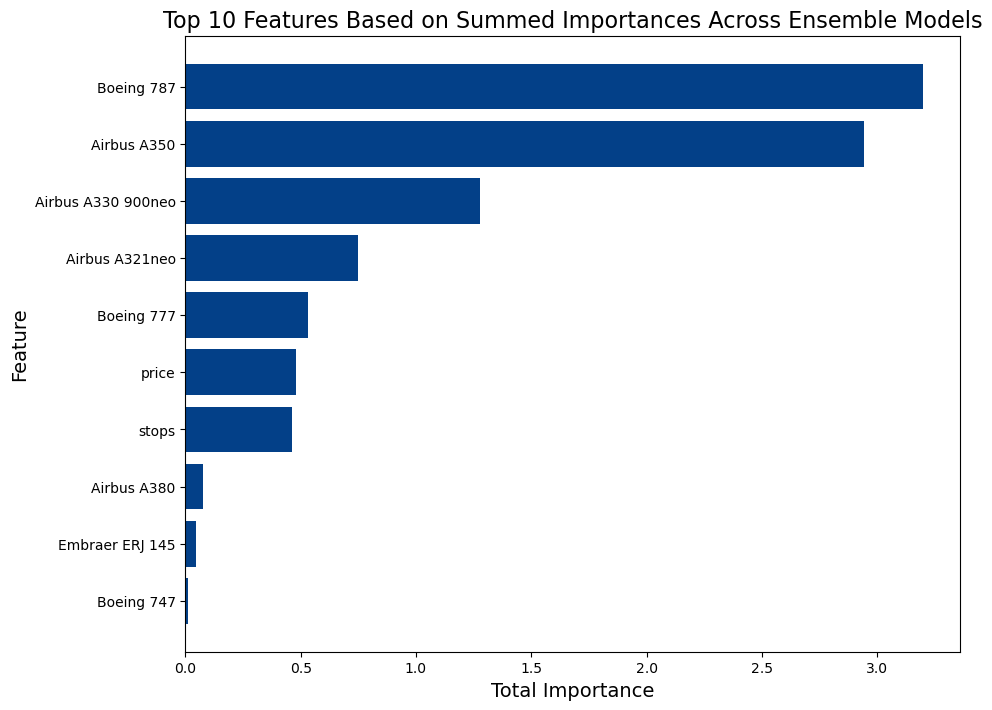

In [67]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting top 10 features based on total importances
ax.barh(features, importance_values, color='#034088')
ax.set_title("Top 10 Features Based on Summed Importances Across Ensemble Models", fontsize=16)
ax.set_xlabel("Total Importance", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.invert_yaxis() 

# Show the plot
plt.show()